
<h1><center><font size="6">MobileNet Architecture Notebook</font></center></h1>


# <a id ='1'>Mounting Google Drive</a>

This notebook was run on Google Colab for GPU acceleration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <a id='2'>Confirming connection to GPU</a>

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# <a id='3'>Importing Packages</a>

In [3]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()
import datetime

from sklearn.model_selection import train_test_split
import pickle

In [4]:
def apk(actual, predicted, k=3):
    """Computes average precision at k between two lists of items"""
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """Computes mean average precision at k between two lists of lists of items"""
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_sim_animals'))
    return sorted([f2cat(f) for f in files], key=str.lower)

def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i] = draw_cv2(raw_strokes, size=size, lw=lw)
    x = x / 255.
    x = x.reshape((len(df), size, size, 1)).astype(np.float32)
    return x



In [5]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/Flictionary'

In [6]:
DP_DIR = os.path.join(base_dir, 'shuffle_csv/')
INPUT_DIR = os.path.join(base_dir, 'kaggle/')
# DP_DIR = os.path.join('../animals/shuffle_csv/')
# INPUT_DIR = os.path.join('../animals/')

BASE_SIZE = 256
NCSVS = 100
NCATS = 47
np.random.seed(seed=42)
tf.random.set_seed(seed=42)



## MobileNet

In [7]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

In [8]:
model = MobileNet(input_shape = (size, size, 1), 
                  alpha = 1., 
                  weights = None, 
                  classes = NCATS)
model.compile(optimizer = Adam(learning_rate = 0.002), 
              loss = 'categorical_crossentropy',
              metrics = [categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

Model: "mobilenet_1.00_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 32, 32, 32)  

## Training with Image Generator

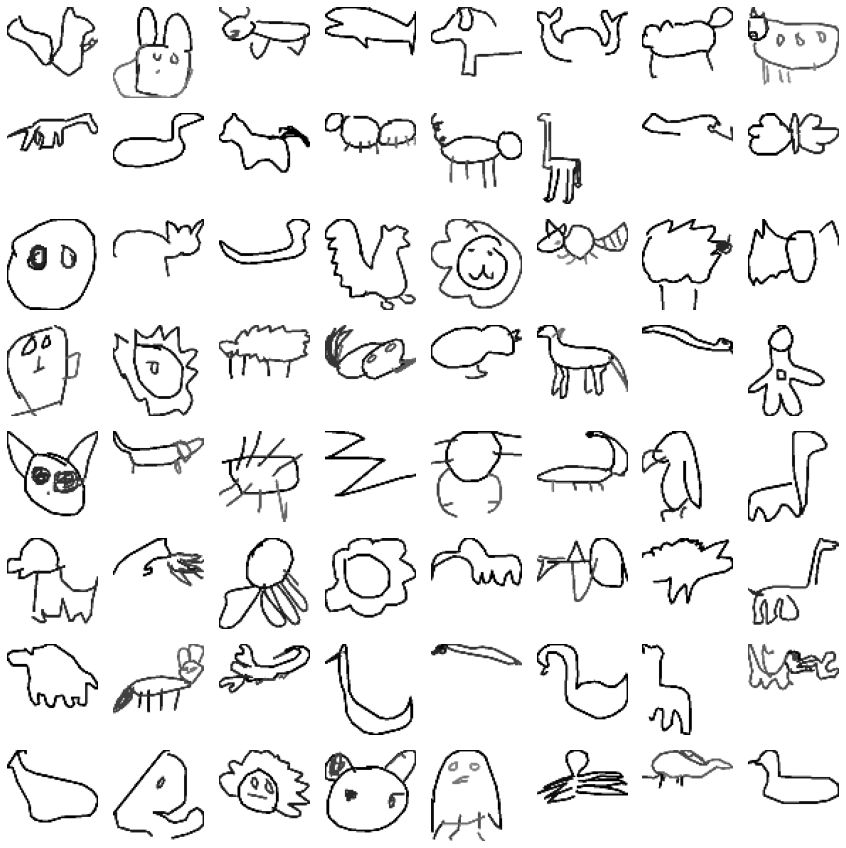

In [ ]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [9]:
frame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/frame2.csv')

In [11]:

X_train, X_valid, y_train, y_valid = train_test_split(frame.drop(['countrycode', 'word', 'key_id', 'target', 'recognized', 'timestamp'], axis=1), 
                                                      frame['target'], 
                                                      test_size = 0.2, 
                                                      random_state = 42)

In [16]:
X_tr = df_to_image_array(X_train, size)
y_tr = tf.keras.utils.to_categorical(y_train, num_classes=NCATS)
print(X_tr.shape, y_tr.shape)

(188000, 64, 64, 1) (188000, 47)


In [17]:
X_val = df_to_image_array(X_valid, size)
y_val = tf.keras.utils.to_categorical(y_valid, num_classes=NCATS)
print(X_val.shape, y_val.shape)

(47000, 64, 64, 1) (47000, 47)


In [19]:
with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_tr2.pickle', 'wb') as f:
    pickle.dump(X_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_tr2.pickle', 'wb') as f:
    pickle.dump(y_tr, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/X_val2.pickle', 'wb') as f:
    pickle.dump(X_val, f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Flictionary/data/y_val2.pickle', 'wb') as f:
    pickle.dump(y_val, f, pickle.HIGHEST_PROTOCOL)

In [20]:
lr_reduction = ReduceLROnPlateau(monitor='val_top_3_accuracy', 
                                 factor=0.75, 
                                 patience=3, 
                                 min_delta=0.001,
                                 mode='max', 
                                 min_lr=1e-5, 
                                 verbose=1)
filepath = '/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet_2/model.{epoch:02d}-{val_loss:.2f}.hdf5'
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor='val_top_3_accuracy', 
                           mode='max')
log_dir = "/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet_2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet_2/log.csv')

In [21]:
histories = []
history = model.fit(X_tr, y_tr, 
                    steps_per_epoch=STEPS, 
                    epochs=20, 
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger]
)
histories.append(history)

Epoch 1/20
800/800 [==============================] - 77s 74ms/step - loss: 1.8609 - categorical_crossentropy: 1.8609 - categorical_accuracy: 0.4750 - top_3_accuracy: 0.6890 - val_loss: 2.0763 - val_categorical_crossentropy: 2.0763 - val_categorical_accuracy: 0.4895 - val_top_3_accuracy: 0.7343

Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet_2/model.01-2.08.hdf5
Epoch 2/20
800/800 [==============================] - 57s 71ms/step - loss: 0.9956 - categorical_crossentropy: 0.9956 - categorical_accuracy: 0.7018 - top_3_accuracy: 0.8847 - val_loss: 1.4704 - val_categorical_crossentropy: 1.4704 - val_categorical_accuracy: 0.6123 - val_top_3_accuracy: 0.8272

Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/Flictionary/logs/log_mobilenet_2/model.02-1.47.hdf5
Epoch 3/20
800/800 [==============================] - 57s 71ms/step - loss: 0.8037 - categorical_crossentropy: 0.8037 - categorical_accuracy: 0.7555 - top_3_accuracy:

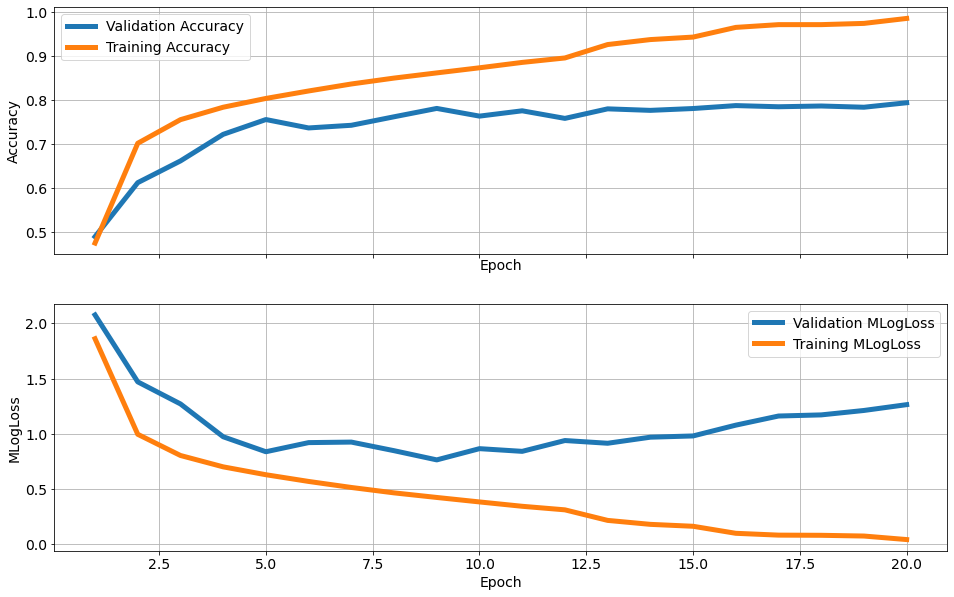

In [22]:
hist_df = pd.concat([pd.DataFrame(history.history) for history in histories], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

In [25]:
valid_predictions = model.predict(X_val, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

368/368 [==============================] - 4s 9ms/step


NameError: ignored

In [26]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2021-09-07 12:12:49.214678.
Total time 2273s
